# Segregation Analysis with PySAL

In [1]:
#%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -v -a "author: eli knaap" -d -u -p segregation,libpysal,geopandas

UsageError: Line magic function `%watermark` not found.


Here, we'll use PySAL's `segregation` module to analyze racial segregation in southern california

In [2]:
import geopandas as gpd

## Data Prep

In [3]:
scag = gpd.read_file("data/scag_region.gpkg", layer="tracts")

We need to reproject the data into a more appropriate coordinate system. UTM11 should work 

In [4]:
scag = scag.to_crs(epsg=26911)
scag.crs

<Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 120°W to 114°W and NAD83 by country
- bounds: (-120.0, 30.88, -114.0, 83.5)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

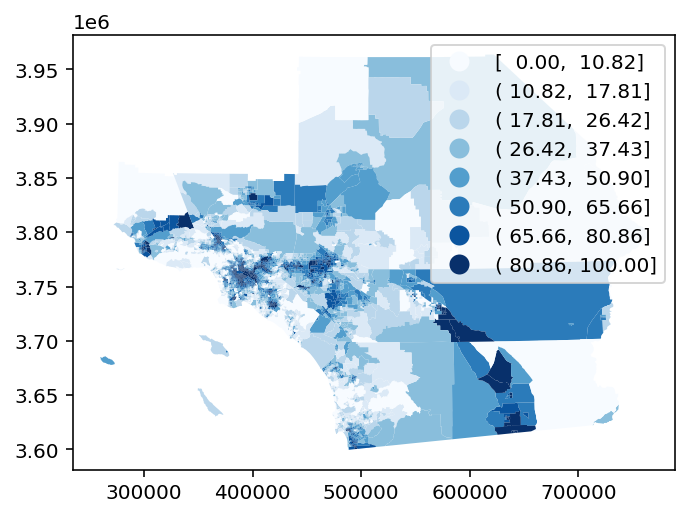

In [5]:
scag.dropna(subset=['p_hispanic_persons']).plot(column='p_hispanic_persons',
                                                scheme='quantiles', 
                                                cmap='Blues',
                                                k=8, 
                                                legend=True)

some background on [fips codes](https://www.policymap.com/2012/08/tips-on-fips-a-quick-guide-to-geographic-place-codes-part-iii/)

In [6]:
scag['county'] = scag.geoid.str[:5]

In [7]:
scag.county.unique()

array(['06037', '06025', '06059', '06071', '06073', '06065', '06111'],
      dtype=object)

In [8]:
county_names = ["Los Angeles", "Imperial", "Orange", "San Bernadino", "San Diego", "Riverside", "Ventura"]

In [9]:
namer = dict(zip(scag.county.unique(), county_names))

In [10]:
namer

{'06037': 'Los Angeles',
 '06025': 'Imperial',
 '06059': 'Orange',
 '06071': 'San Bernadino',
 '06073': 'San Diego',
 '06065': 'Riverside',
 '06111': 'Ventura'}

Now that we know which county is which, we could just use these codes to divide up the region into pieces. But lets go ahead and replace the codes with their names. It's more to type, but if we want to subset later, we won't have to go look up the codes again

In [11]:
scag['county'] = scag.county.replace(to_replace=namer)

In [12]:
scag.county

0       Los Angeles
1       Los Angeles
2       Los Angeles
3       Los Angeles
4       Los Angeles
           ...     
4575    Los Angeles
4576    Los Angeles
4577        Ventura
4578      Riverside
4579    Los Angeles
Name: county, Length: 4580, dtype: object

In [13]:
coastal = scag[scag.county.isin(["Los Angeles", "Orange", "San Diego", "Ventura"])]

In [14]:
inland = scag[scag.county.isin(['Riverside', "San Bernadino", "Imperial"])]

<AxesSubplot:>

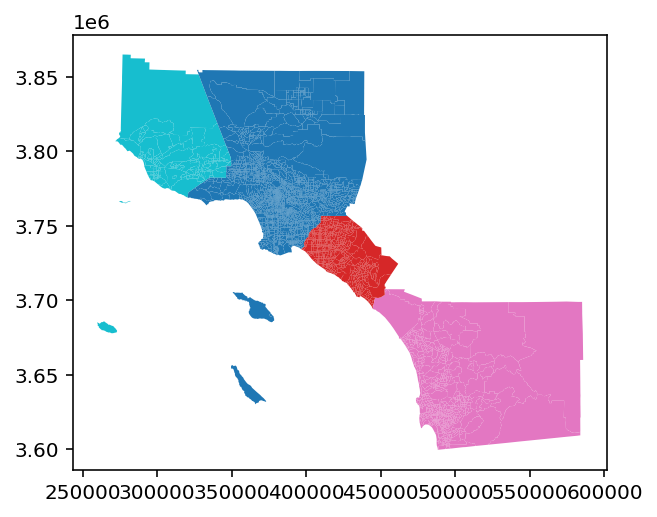

In [15]:
coastal.plot(column='county')

<AxesSubplot:>

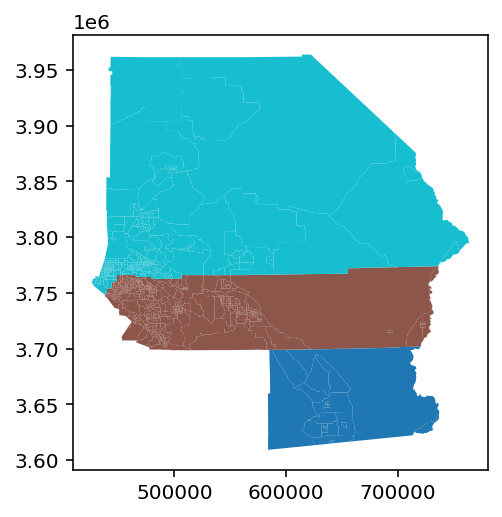

In [18]:
inland.plot(column='county')

## Calculating Segregation Measures

### Classic (aspatial) Single-Group Indices

In [52]:
from segregation.aspatial import Dissim, GiniSeg, Entropy

In [22]:
dissim = Dissim(scag, "n_hispanic_persons", "n_total_pop")
gini = GiniSeg(scag, "n_hispanic_persons", "n_total_pop")
entropy = Entropy(scag, "n_hispanic_persons", "n_total_pop")

In [23]:
dissim.statistic

0.4820197253710138

In [24]:
gini.statistic

0.6368128074464425

In [25]:
entropy.statistic

0.24939370275933018

### Multigroup Indices

In [20]:
from segregation.aspatial import MultiInformationTheory, MultiGiniSeg, MultiDiversity

In [21]:
pop_groups = ['n_asian_persons', 'n_hispanic_persons', 'n_nonhisp_black_persons', 'n_nonhisp_white_persons']

In [22]:
multi_div = MultiDiversity(scag, pop_groups)
multi_info = MultiInformationTheory(scag, pop_groups)

In [17]:
multi_div.statistic

1.1649555024744425

In [18]:
multi_info.statistic

0.27621346024237237

### Spatial Indices

In [17]:
from libpysal import weights

In [18]:
from segregation.spatial import SpatialDissim,  SpatialInformationTheory

In [19]:
w_queen = weights.Queen.from_dataframe(scag)
w_dist = weights.DistanceBand.from_dataframe(scag, 2500)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 4285.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 421 disconnected components.
 There are 362 islands with ids: 157, 159, 162, 163, 164, 165, 209, 243, 245, 276, 344, 405, 415, 437, 447, 457, 481, 482, 484, 489, 490, 492, 518, 774, 873, 907, 908, 963, 970, 971, 972, 973, 1017, 1053, 1055, 1070, 1105, 1118, 1158, 1167, 1209, 1221, 1295, 1374, 1424, 1433, 1435, 1477, 1486, 1492, 1512, 1543, 1544, 1565, 1571, 1572, 1574, 1575, 1583, 1603, 1606, 1611, 1612, 1613, 1628, 1636, 1637, 1639, 1656, 1660, 1661, 1669, 1670, 1679, 1694, 1696, 1698, 1699, 1702, 1719, 1720, 1727, 1729, 1737, 1741, 1743, 1744, 1746, 1757, 1758

#### Single Group

In [23]:
spatial_dissim = SpatialDissim(scag, 'n_hispanic_persons', 'n_total_pop', w=w_queen)

In [24]:
spatial_dissim.statistic

0.35351598194379474

In [25]:
spatial_dissim_dist = SpatialDissim(scag, 'n_hispanic_persons', 'n_total_pop', w=w_dist)

In [26]:
spatial_dissim_dist.statistic

0.3252763548500947

#### Multi Group

we can also look at how different concepts of space influence the resulting index statistic

In [16]:
spatial_info_queen = SpatialInformationTheory(scag, pop_groups, w=w_queen)
spatial_info_dist = SpatialInformationTheory(scag, pop_groups, w=w_dist)

NameError: name 'SpatialInformationTheory' is not defined

In [28]:
spatial_info_queen.statistic

0.21447331455751437

In [25]:
spatial_info_dist.statistic

0.21947469354446483

#### Multiscalar Profile

The multiscalar segregation profile is a way of measuring how global versus local the segregation patterns are in a region. 

In [41]:
from segregation.spatial import compute_segregation_profile

In [42]:
distances = [1500., 2500., 3500., 4500., 5500.]

In [43]:
prof = compute_segregation_profile(scag, pop_groups, distances)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1167 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 258 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 196 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 152 disconnected components.
  warnings.warn(message)


<AxesSubplot:>

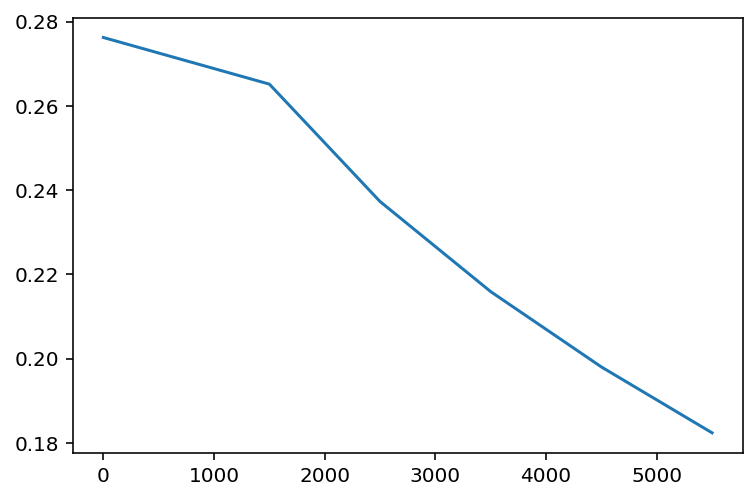

In [44]:
import pandas as pd
pd.Series(prof).plot()

We can also look at how the segregation profiles differ by region. If we plot them all on the same graph, we can compare the slopes of the lines to see how the shape of segregation differs between places in the southern cal region

In [45]:
coastal_prof = compute_segregation_profile(coastal, pop_groups, distances)
inland_prof = compute_segregation_profile(inland, pop_groups, distances)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 660 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 197 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 119 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 85 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weig

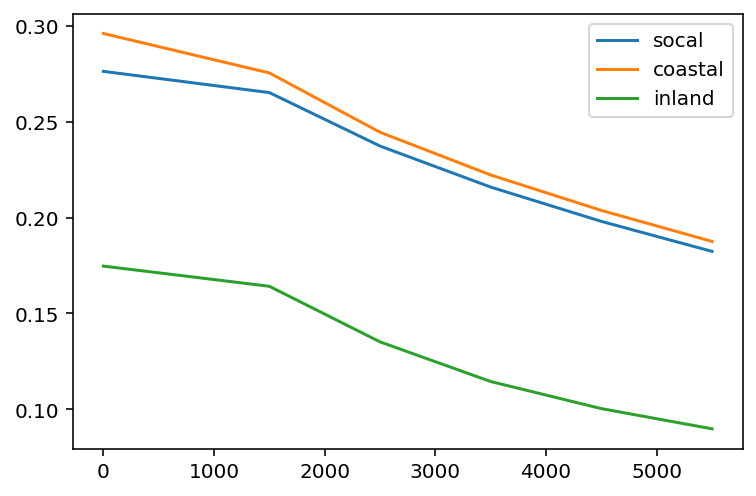

In [46]:

pd.Series(prof, name='socal').plot(legend=True)
pd.Series(coastal_prof, name='coastal').plot(legend=True)
pd.Series(inland_prof, name='inland').plot(legend=True)

This shows that segregation in the coastal region is considerably larger than the inland region at every scale, though have similar shapes to their overall segregation profiles.

## Single-Value Inference

In [54]:
from segregation.inference import SingleValueTest

In [55]:
entropy_test = SingleValueTest(entropy)

NameError: name 'entropy' is not defined

In [56]:
dissim_test = SingleValueTest(dissim)

NameError: name 'dissim' is not defined

In [57]:
entropy_test.p_value

NameError: name 'entropy_test' is not defined

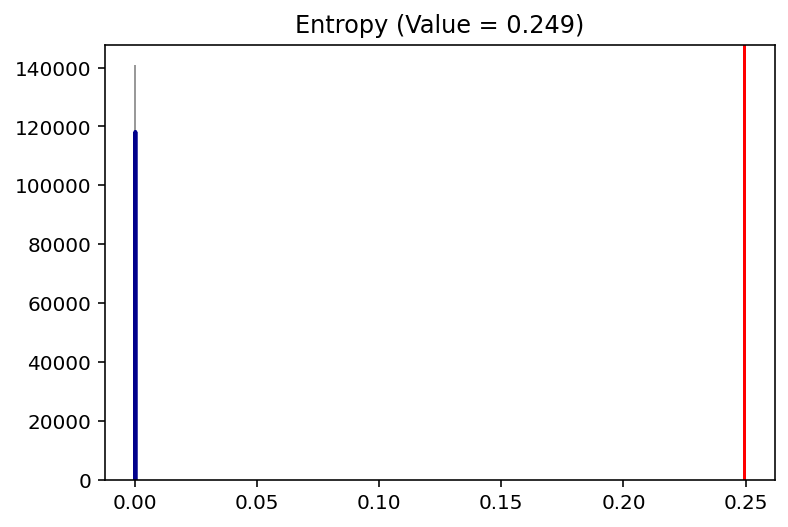

In [54]:
entropy_test.plot()

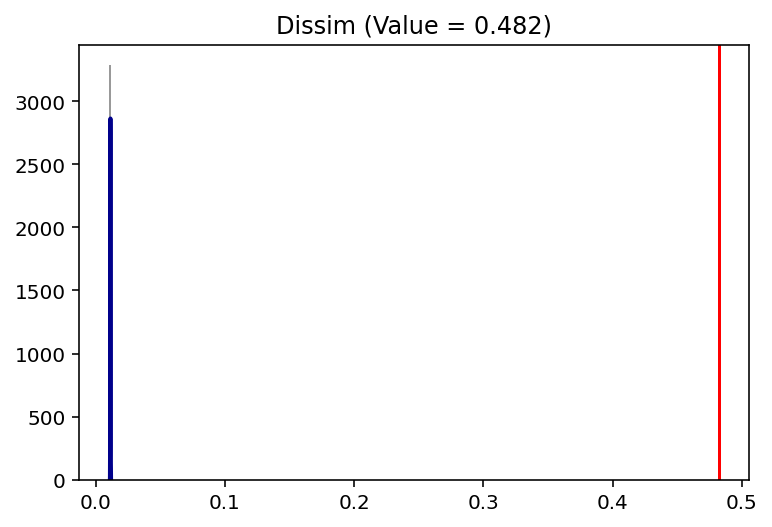

In [55]:
dissim_test.plot()

## Comparative Inference

In [58]:
from segregation.inference import TwoValueTest

In [24]:
info_test = TwoValueTest(MultiInformationTheory(coastal, pop_groups),
            MultiInformationTheory(inland, pop_groups))

In [ ]:
info_test.est_point_diff

In [ ]:
info_test.plot()

## Decomposition

In [23]:
from segregation.decomposition import DecomposeSegregation

In [24]:
w_coastal = weights.DistanceBand.from_dataframe(coastal, 2000)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 304 disconnected components.
 There are 253 islands with ids: 209, 344, 393, 461, 481, 482, 539, 774, 796, 873, 923, 963, 1053, 1055, 1082, 1118, 1141, 1158, 1167, 1209, 1211, 1295, 1374, 1412, 1543, 1544, 1571, 1572, 1583, 1584, 1603, 1611, 1612, 1613, 1621, 1628, 1637, 1639, 1640, 1642, 1656, 1660, 1669, 1670, 1679, 1699, 1727, 1729, 1746, 1757, 1758, 1786, 1813, 1851, 1852, 1856, 1867, 1931, 1933, 1950, 2000, 2012, 2017, 2019, 2021, 2022, 2033, 2035, 2077, 2091, 2119, 2137, 2174, 2175, 2177, 2178, 2185, 2231, 2240, 2242, 2253, 2254, 2260, 2292, 2313, 2330, 2368, 2379, 2388, 2398, 2399, 2414, 2433, 2439, 2443, 2446, 2447, 2462, 2482, 2483, 2485, 2486, 2487, 2488, 2499, 2500, 2501, 2503, 2539, 2540, 2586, 2601, 2604, 2618, 2629, 2642, 2643, 2671, 2672, 2674, 2675, 2678, 2690, 2706, 2725, 2729, 2770, 2784, 2794, 279

In [25]:
w_inland = weights.DistanceBand.from_dataframe(inland, 2000)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 324 disconnected components.
 There are 275 islands with ids: 157, 159, 161, 162, 163, 164, 165, 171, 236, 240, 241, 243, 245, 276, 289, 405, 406, 415, 437, 444, 447, 453, 457, 459, 484, 489, 490, 491, 492, 500, 518, 679, 877, 907, 908, 947, 970, 971, 972, 973, 1017, 1066, 1070, 1105, 1168, 1212, 1221, 1222, 1230, 1390, 1394, 1413, 1424, 1426, 1427, 1433, 1435, 1444, 1477, 1486, 1492, 1512, 1559, 1565, 1574, 1575, 1592, 1605, 1606, 1636, 1661, 1663, 1694, 1696, 1697, 1698, 1702, 1719, 1720, 1737, 1738, 1741, 1743, 1744, 1762, 1763, 1764, 1782, 1784, 1794, 1800, 1805, 1807, 1861, 1863, 1873, 1876, 1879, 1892, 1954, 1955, 1956, 1957, 1959, 1963, 1964, 1965, 1966, 1993, 2004, 2005, 2024, 2027, 2029, 2282, 2312, 2318, 2319, 2320, 2321, 2331, 2334, 2337, 2338, 2339, 2341, 2342, 2359, 2375, 2418, 2419, 2420, 2429, 2430, 2

In [26]:
one = SpatialDissim(coastal, 'n_nonhisp_black_persons', 'n_total_pop', w=w_coastal)

In [27]:
decomp = DecomposeSegregation(SpatialDissim(coastal, 'n_nonhisp_black_persons', 'n_total_pop', w=w_coastal),
                    SpatialDissim(inland,'n_nonhisp_black_persons', 'n_total_pop', w=w_inland))

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3502.
  warnings.warn(message)


In [42]:
decomp2._counterfac_df1

geometry  compl_pop_var  \
0     POLYGON ((366469.563 3781383.126, 367274.483 3...         5370.0   
1     POLYGON ((356092.650 3787689.748, 356495.424 3...         5541.0   
2     POLYGON ((354475.384 3787187.145, 354877.807 3...         4310.0   
3     POLYGON ((351261.835 3787675.698, 351660.293 3...         2766.0   
4     POLYGON ((384094.466 3756080.750, 384101.839 3...         2242.0   
...                                                 ...            ...   
4574  POLYGON ((396055.227 3839180.600, 396524.754 3...         4909.0   
4575  POLYGON ((361824.956 3810425.146, 362123.556 3...         3556.0   
4576  POLYGON ((388383.492 3752560.445, 388471.174 3...         4029.0   
4577  POLYGON ((295282.054 3784488.316, 295656.799 3...         6456.0   
4579  POLYGON ((369710.362 3782951.381, 369911.648 3...         3734.0   

         share  compl_share  counterfactual_group_pop  \
0     0.000125     0.000341                212.409214   
1     0.000116     0.000351                190.853149   
2     0.000173     0.000273                267.201582   
3     0.000155     0.000175                245.832060   
4     0.001154     0.000142                884.682724   
...        ...          ...                       ...   
4574  0.001541     0.000311               1071.194072   
4575  0.000114     0.000226                188.215171   
4576  0.001208     0.000256                919.248529   
4577  0.000304     0.000409                409.473094   
4579  0.000256     0.000237                358.759719   

      counterfactual_compl_pop  counterfactual_total_pop  group_composition  \
0                  5337.875332               5550.284546           0.023104   
1                  5512.145720               5702.998869           0.020852   
2                  4280.625644               4547.827226           0.039233   
3                  2642.254902               2888.086962           0.054036   
4                  2089.855020               2974.537744           0.343485   
...                        ...                       ...                ...   
4574               4825.221137               5896.415209           0.241853   
4575               3505.295242               3693.510413           0.031590   
4576               4014.418560               4933.667089           0.233593   
4577               6588.429985               6997.903079           0.045676   
4579               3680.008849               4038.768569           0.065098   

      counterfactual_composition  
0                       0.038270  
1                       0.033465  
2                       0.058754  
3                       0.085119  
4                       0.297419  
...                          ...  
4574                    0.181669  
4575                    0.050958  
4576                    0.186322  
4577                    0.058514  
4579                    0.088829  

[3727 rows x 9 columns]

In [29]:
decomp._counterfac_df2

geometry  group_composition  \
133   POLYGON ((633077.814 3629999.424, 633076.070 3...           0.016627   
134   POLYGON ((633890.784 3630009.725, 633891.204 3...           0.039791   
135   POLYGON ((631587.523 3627086.044, 632400.439 3...           0.001896   
136   POLYGON ((637828.809 3614926.587, 637906.927 3...           0.000000   
157   POLYGON ((460119.246 3818467.127, 460093.757 3...           0.204120   
...                                                 ...                ...   
4568  POLYGON ((484121.605 3727247.717, 485740.020 3...           0.057496   
4569  POLYGON ((503825.579 3734979.552, 504229.366 3...           0.057220   
4570  POLYGON ((469815.539 3770501.637, 469819.479 3...           0.010735   
4571  POLYGON ((483295.751 3765867.745, 483631.412 3...           0.028944   
4578  POLYGON ((545291.070 3740644.561, 545284.392 3...           0.012747   

      counterfactual_group_pop  counterfactual_total_pop  \
133                  33.093828                    5413.0   
134                 117.949241                    5931.0   
135                   0.000000                    6329.0   
136                   0.000000                    7242.0   
157                2854.862705                    8931.0   
...                        ...                       ...   
4568                197.677620                    6157.0   
4569                 93.625272                    2971.0   
4570                 13.722308                    4285.0   
4571                127.644294                    8672.0   
4578                 12.319069                    2981.0   

      counterfactual_composition  
133                     0.006114  
134                     0.019887  
135                     0.000000  
136                     0.000000  
157                     0.319658  
...                          ...  
4568                    0.032106  
4569                    0.031513  
4570                    0.003202  
4571                    0.014719  
4578                    0.004133  

[853 rows x 5 columns]

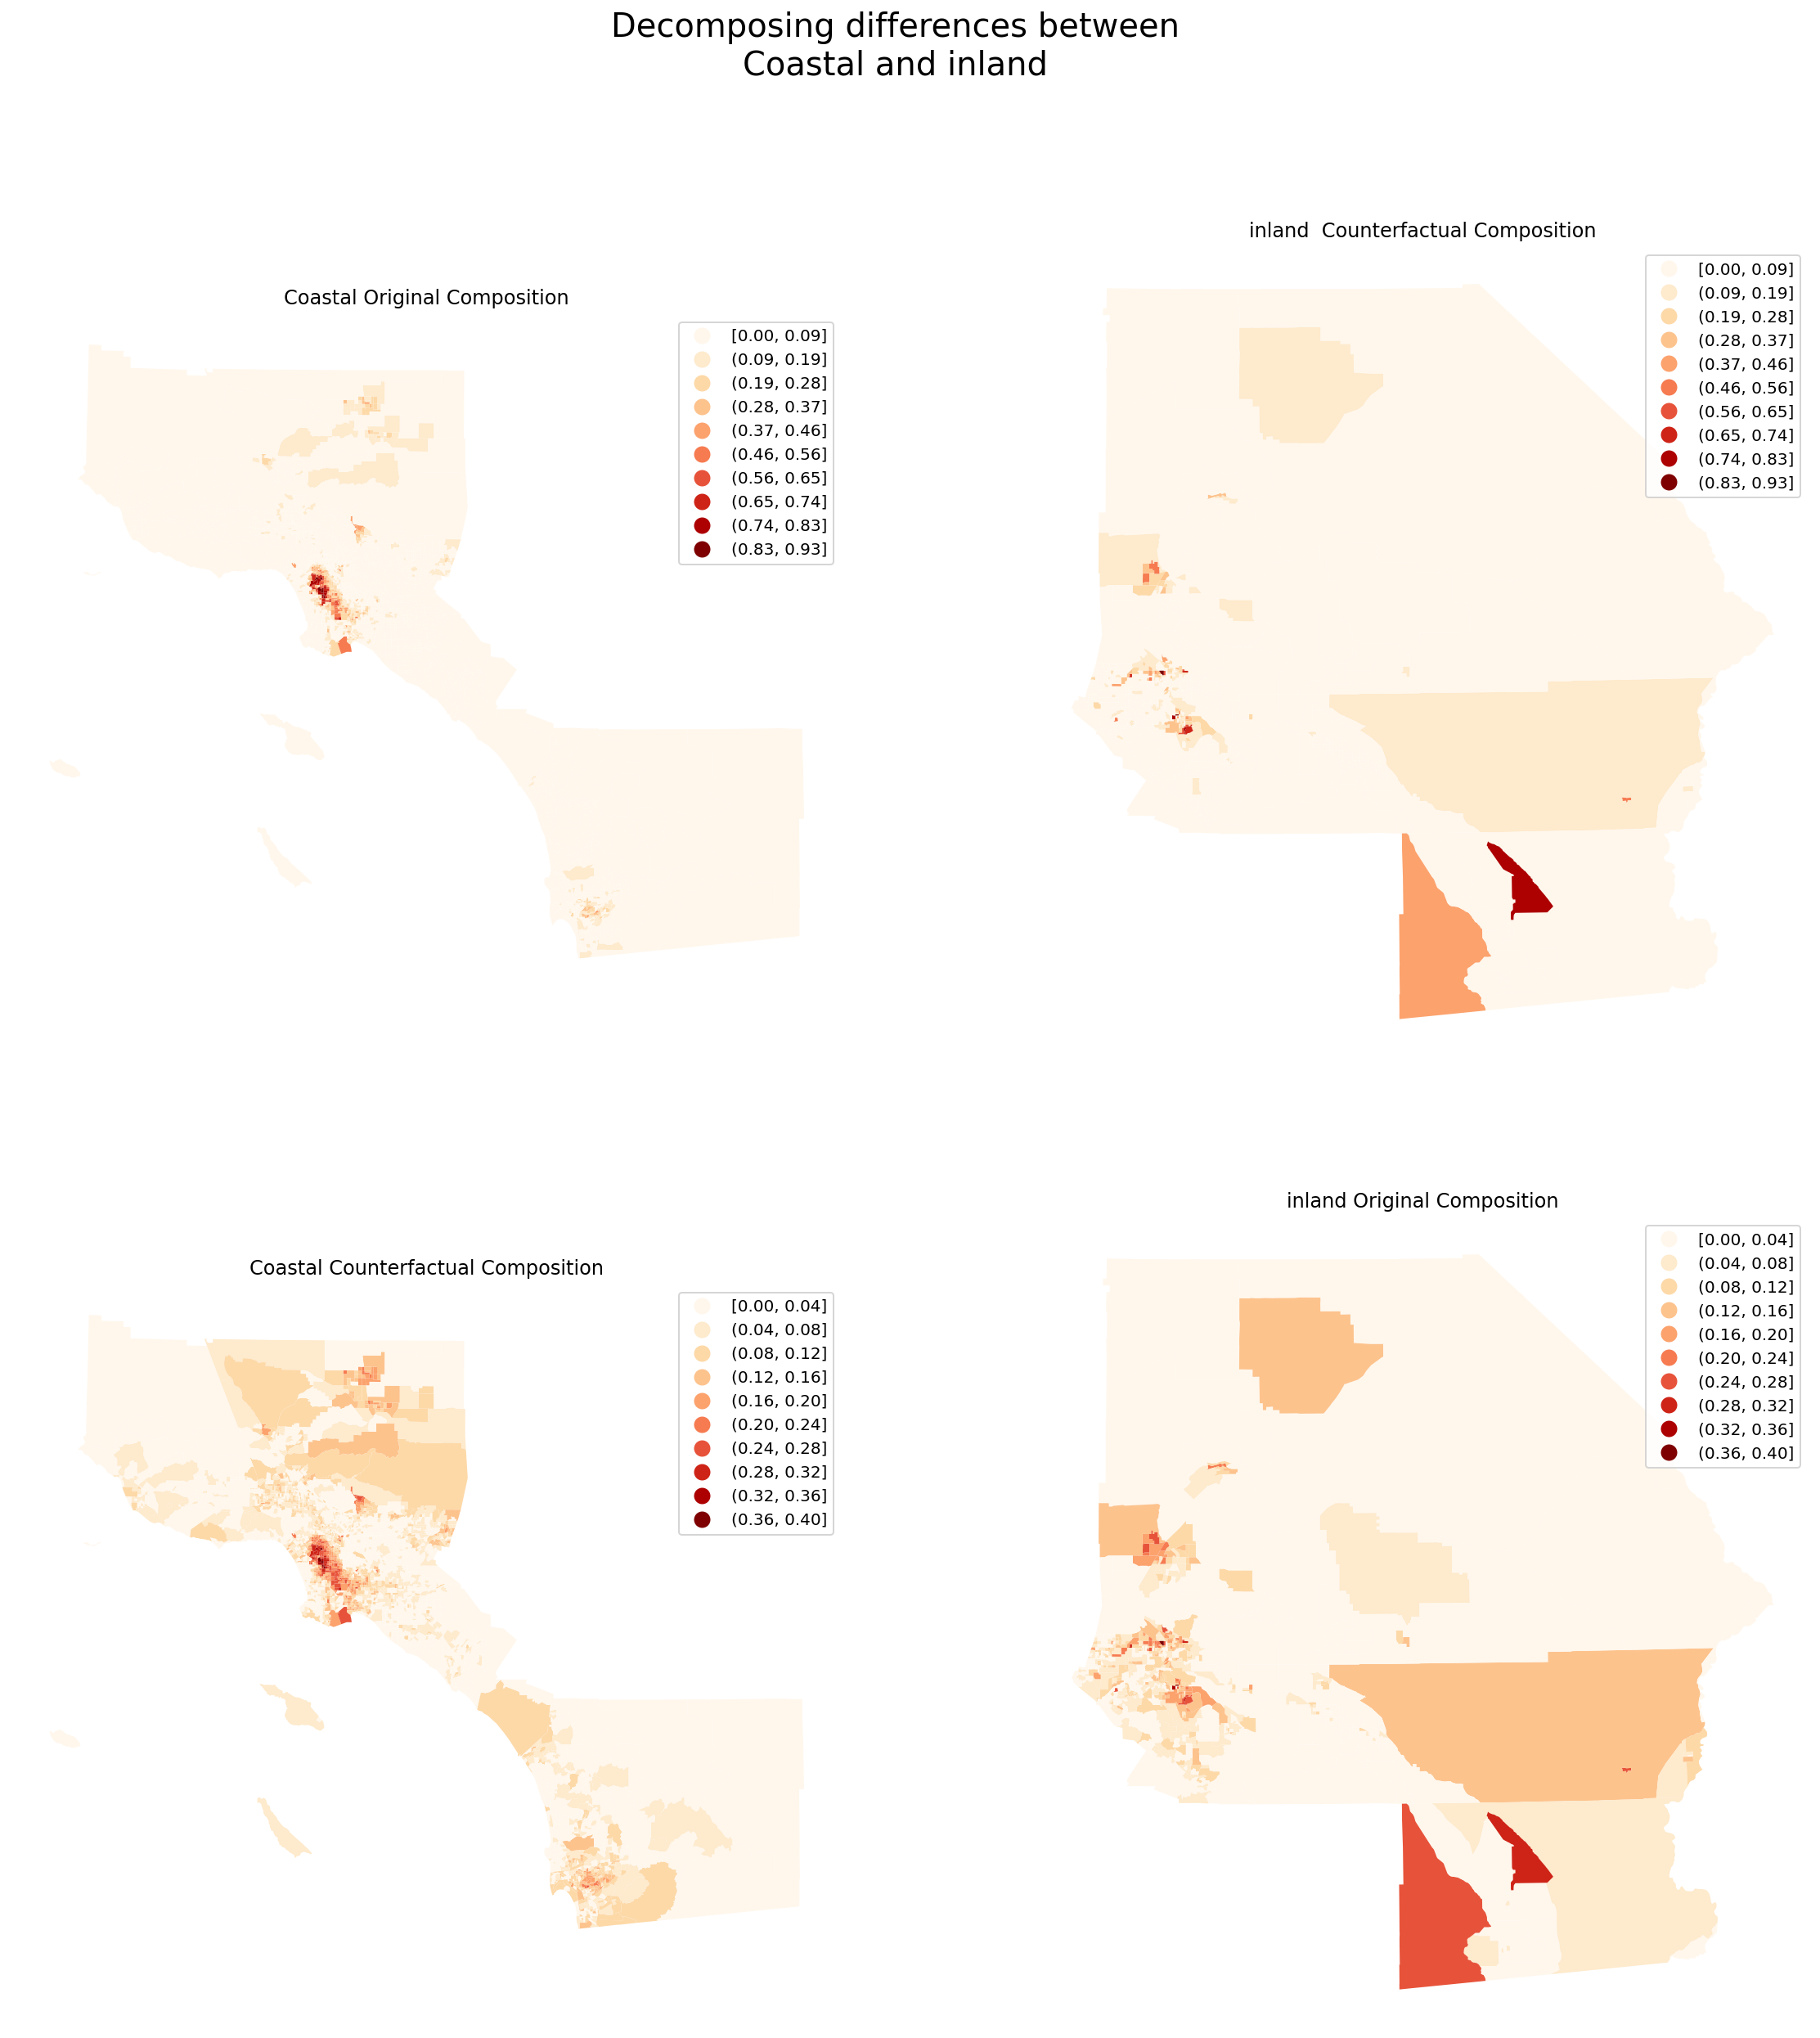

In [30]:
decomp.plot(plot_type='maps', figsize=(20,20), scheme='equalinterval', k=10, city_a='Coastal', city_b='inland')

<AxesSubplot:title={'center':'Spatial Component = 0.024, Attribute Component: 0.152'}, xlabel='group_composition', ylabel='Proportion'>

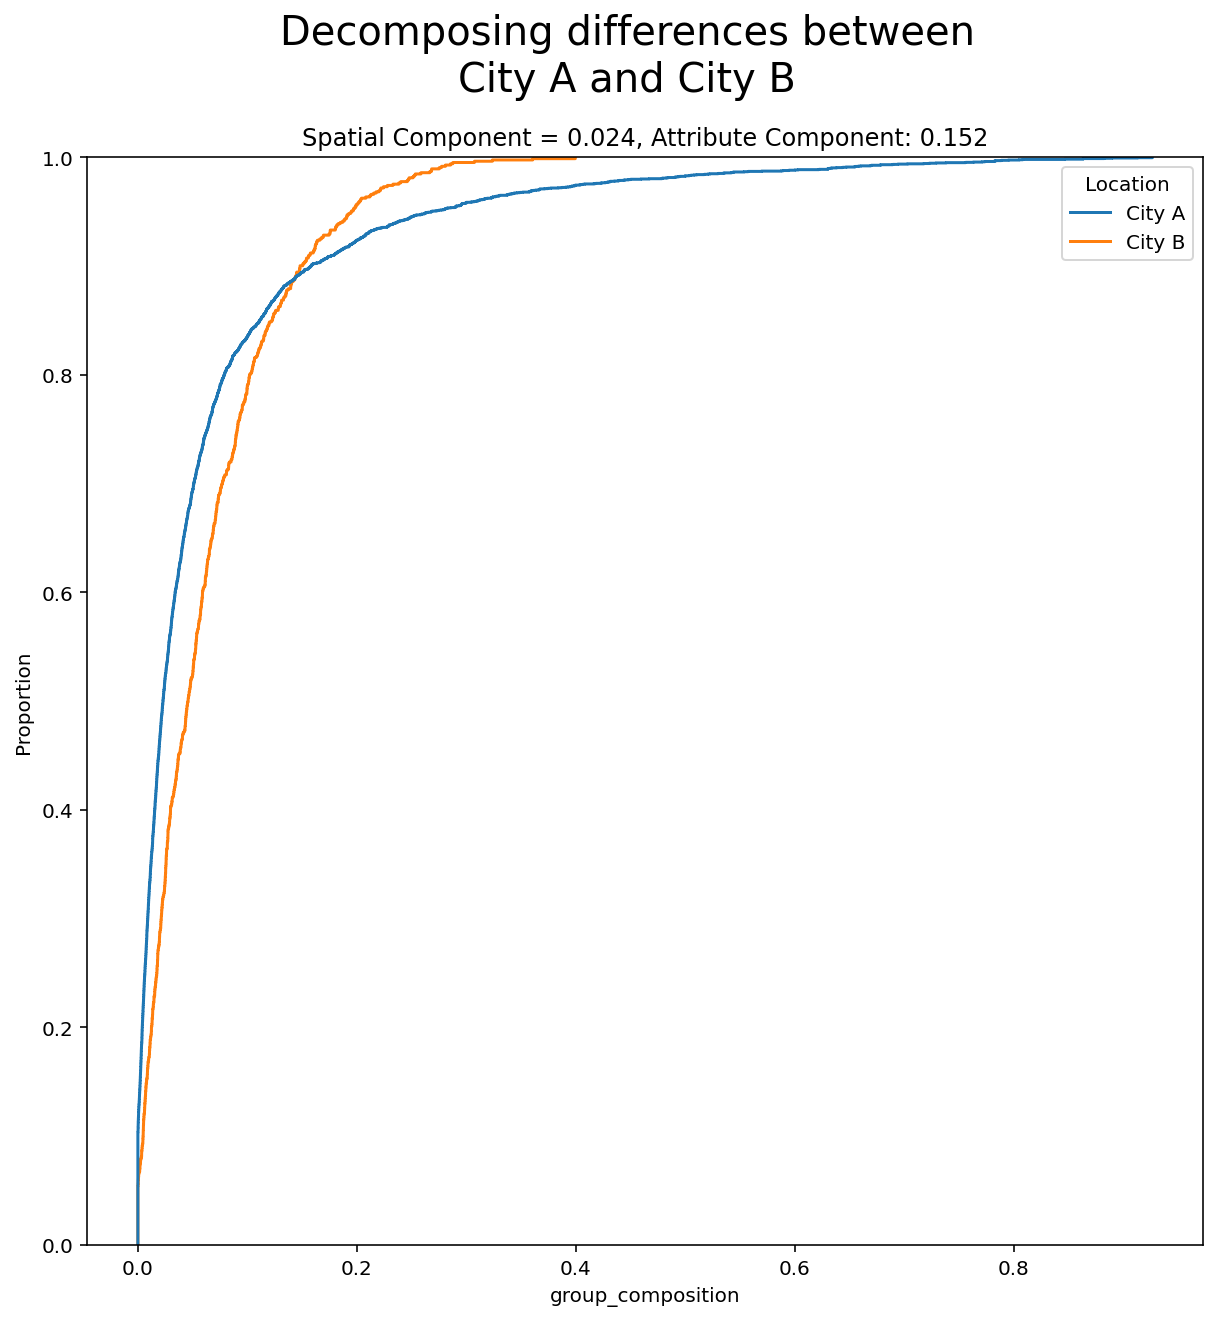

In [39]:
decomp.plot()

In [40]:
decomp2 = DecomposeSegregation(SpatialDissim(coastal, 'n_nonhisp_black_persons', 'n_total_pop', w=w_coastal),
                    SpatialDissim(inland,'n_nonhisp_black_persons', 'n_total_pop', w=w_inland), counterfactual_approach='share')

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3502.
  warnings.warn(message)


<AxesSubplot:title={'center':'Spatial Component = 0.071, Attribute Component: 0.104'}, xlabel='share', ylabel='Proportion'>

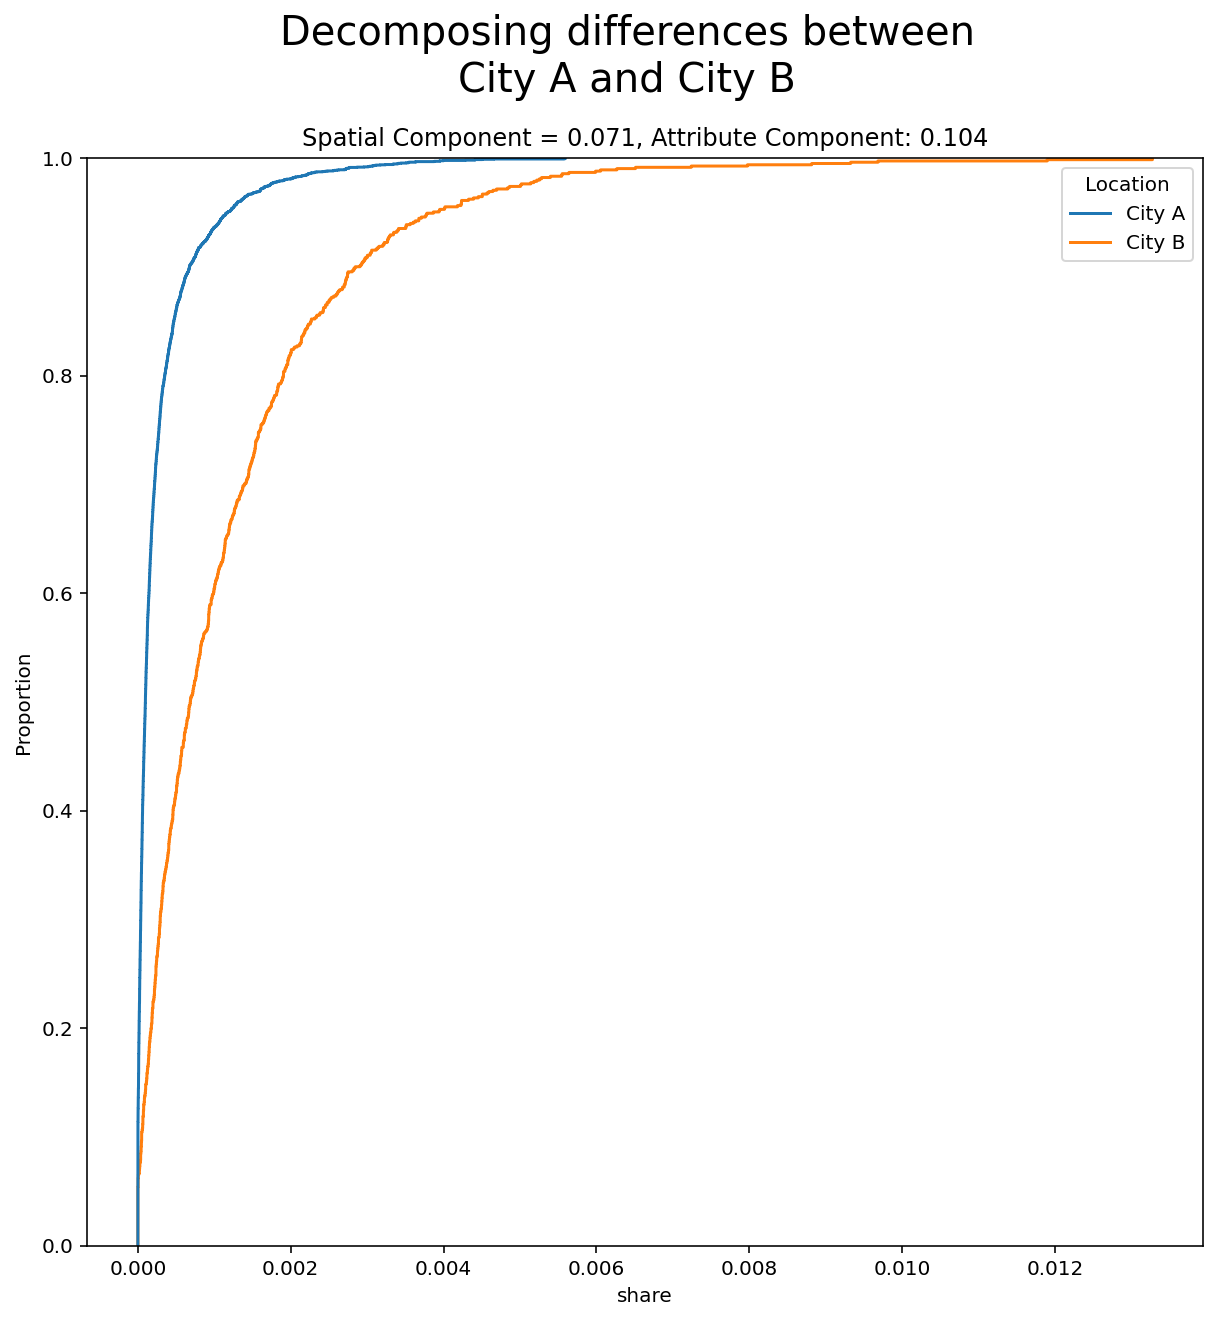

In [43]:
decomp2.plot()

In [44]:
decomp3 = DecomposeSegregation(SpatialDissim(coastal, 'n_nonhisp_black_persons', 'n_total_pop', w=w_coastal),
                    SpatialDissim(inland,'n_nonhisp_black_persons', 'n_total_pop', w=w_inland), counterfactual_approach='dual_composition')

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3502.
  warnings.warn(message)


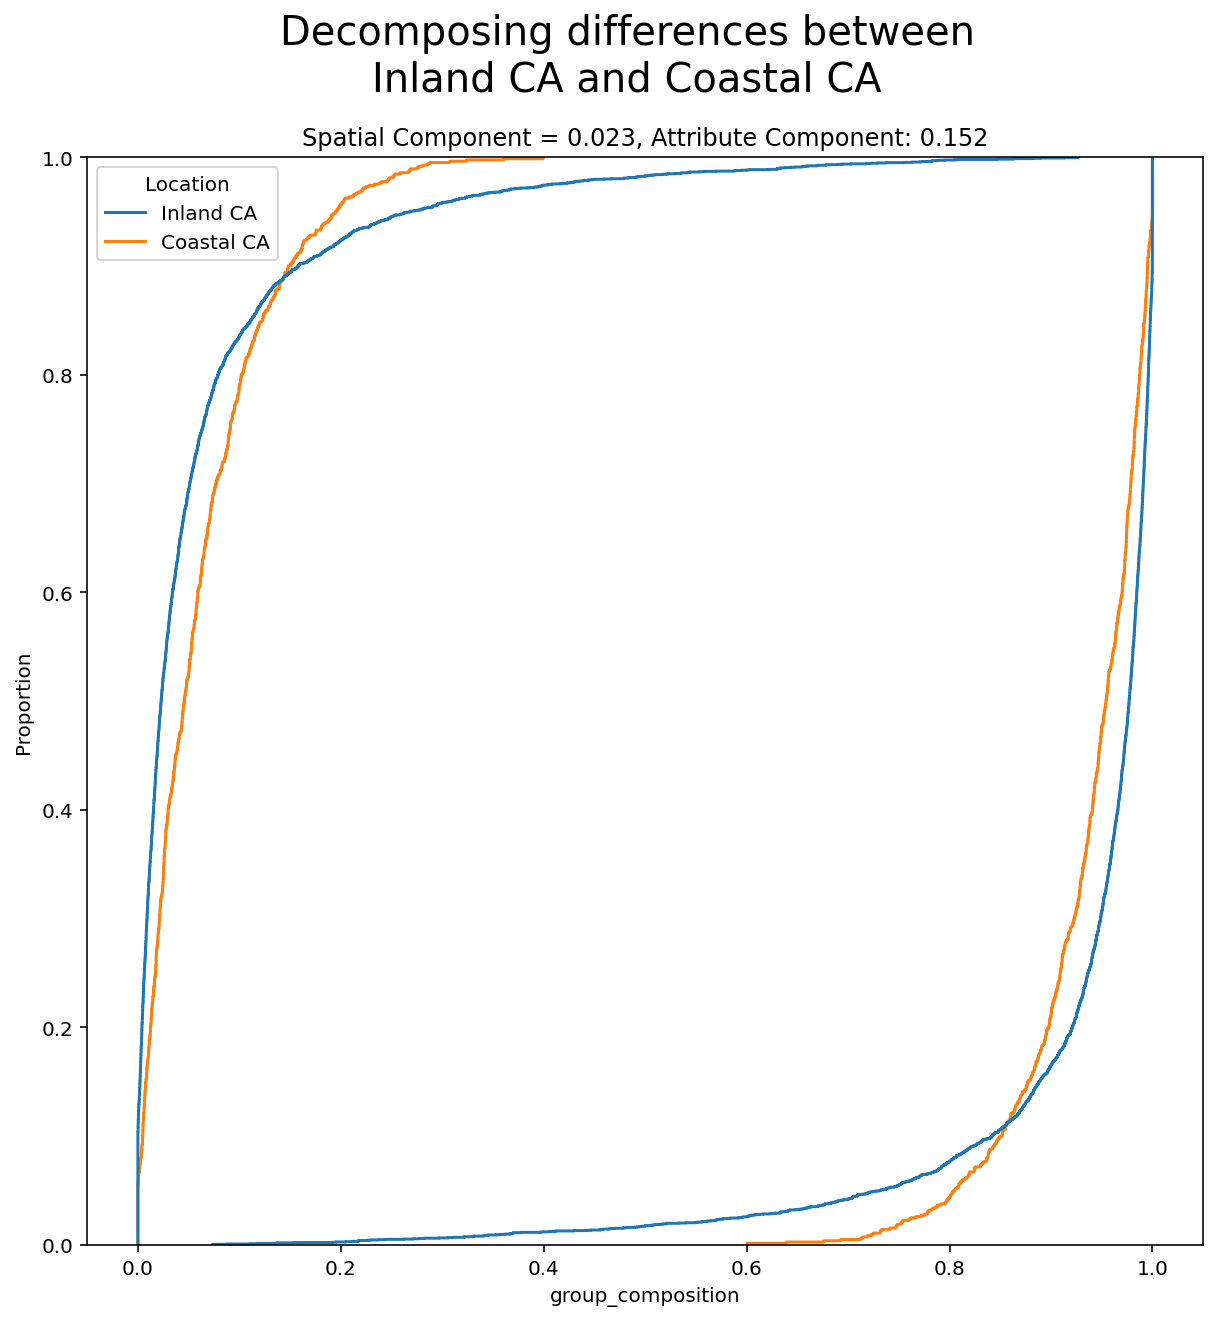

In [50]:
decomp3.plot(city_a='Inland CA', city_b='Coastal CA')

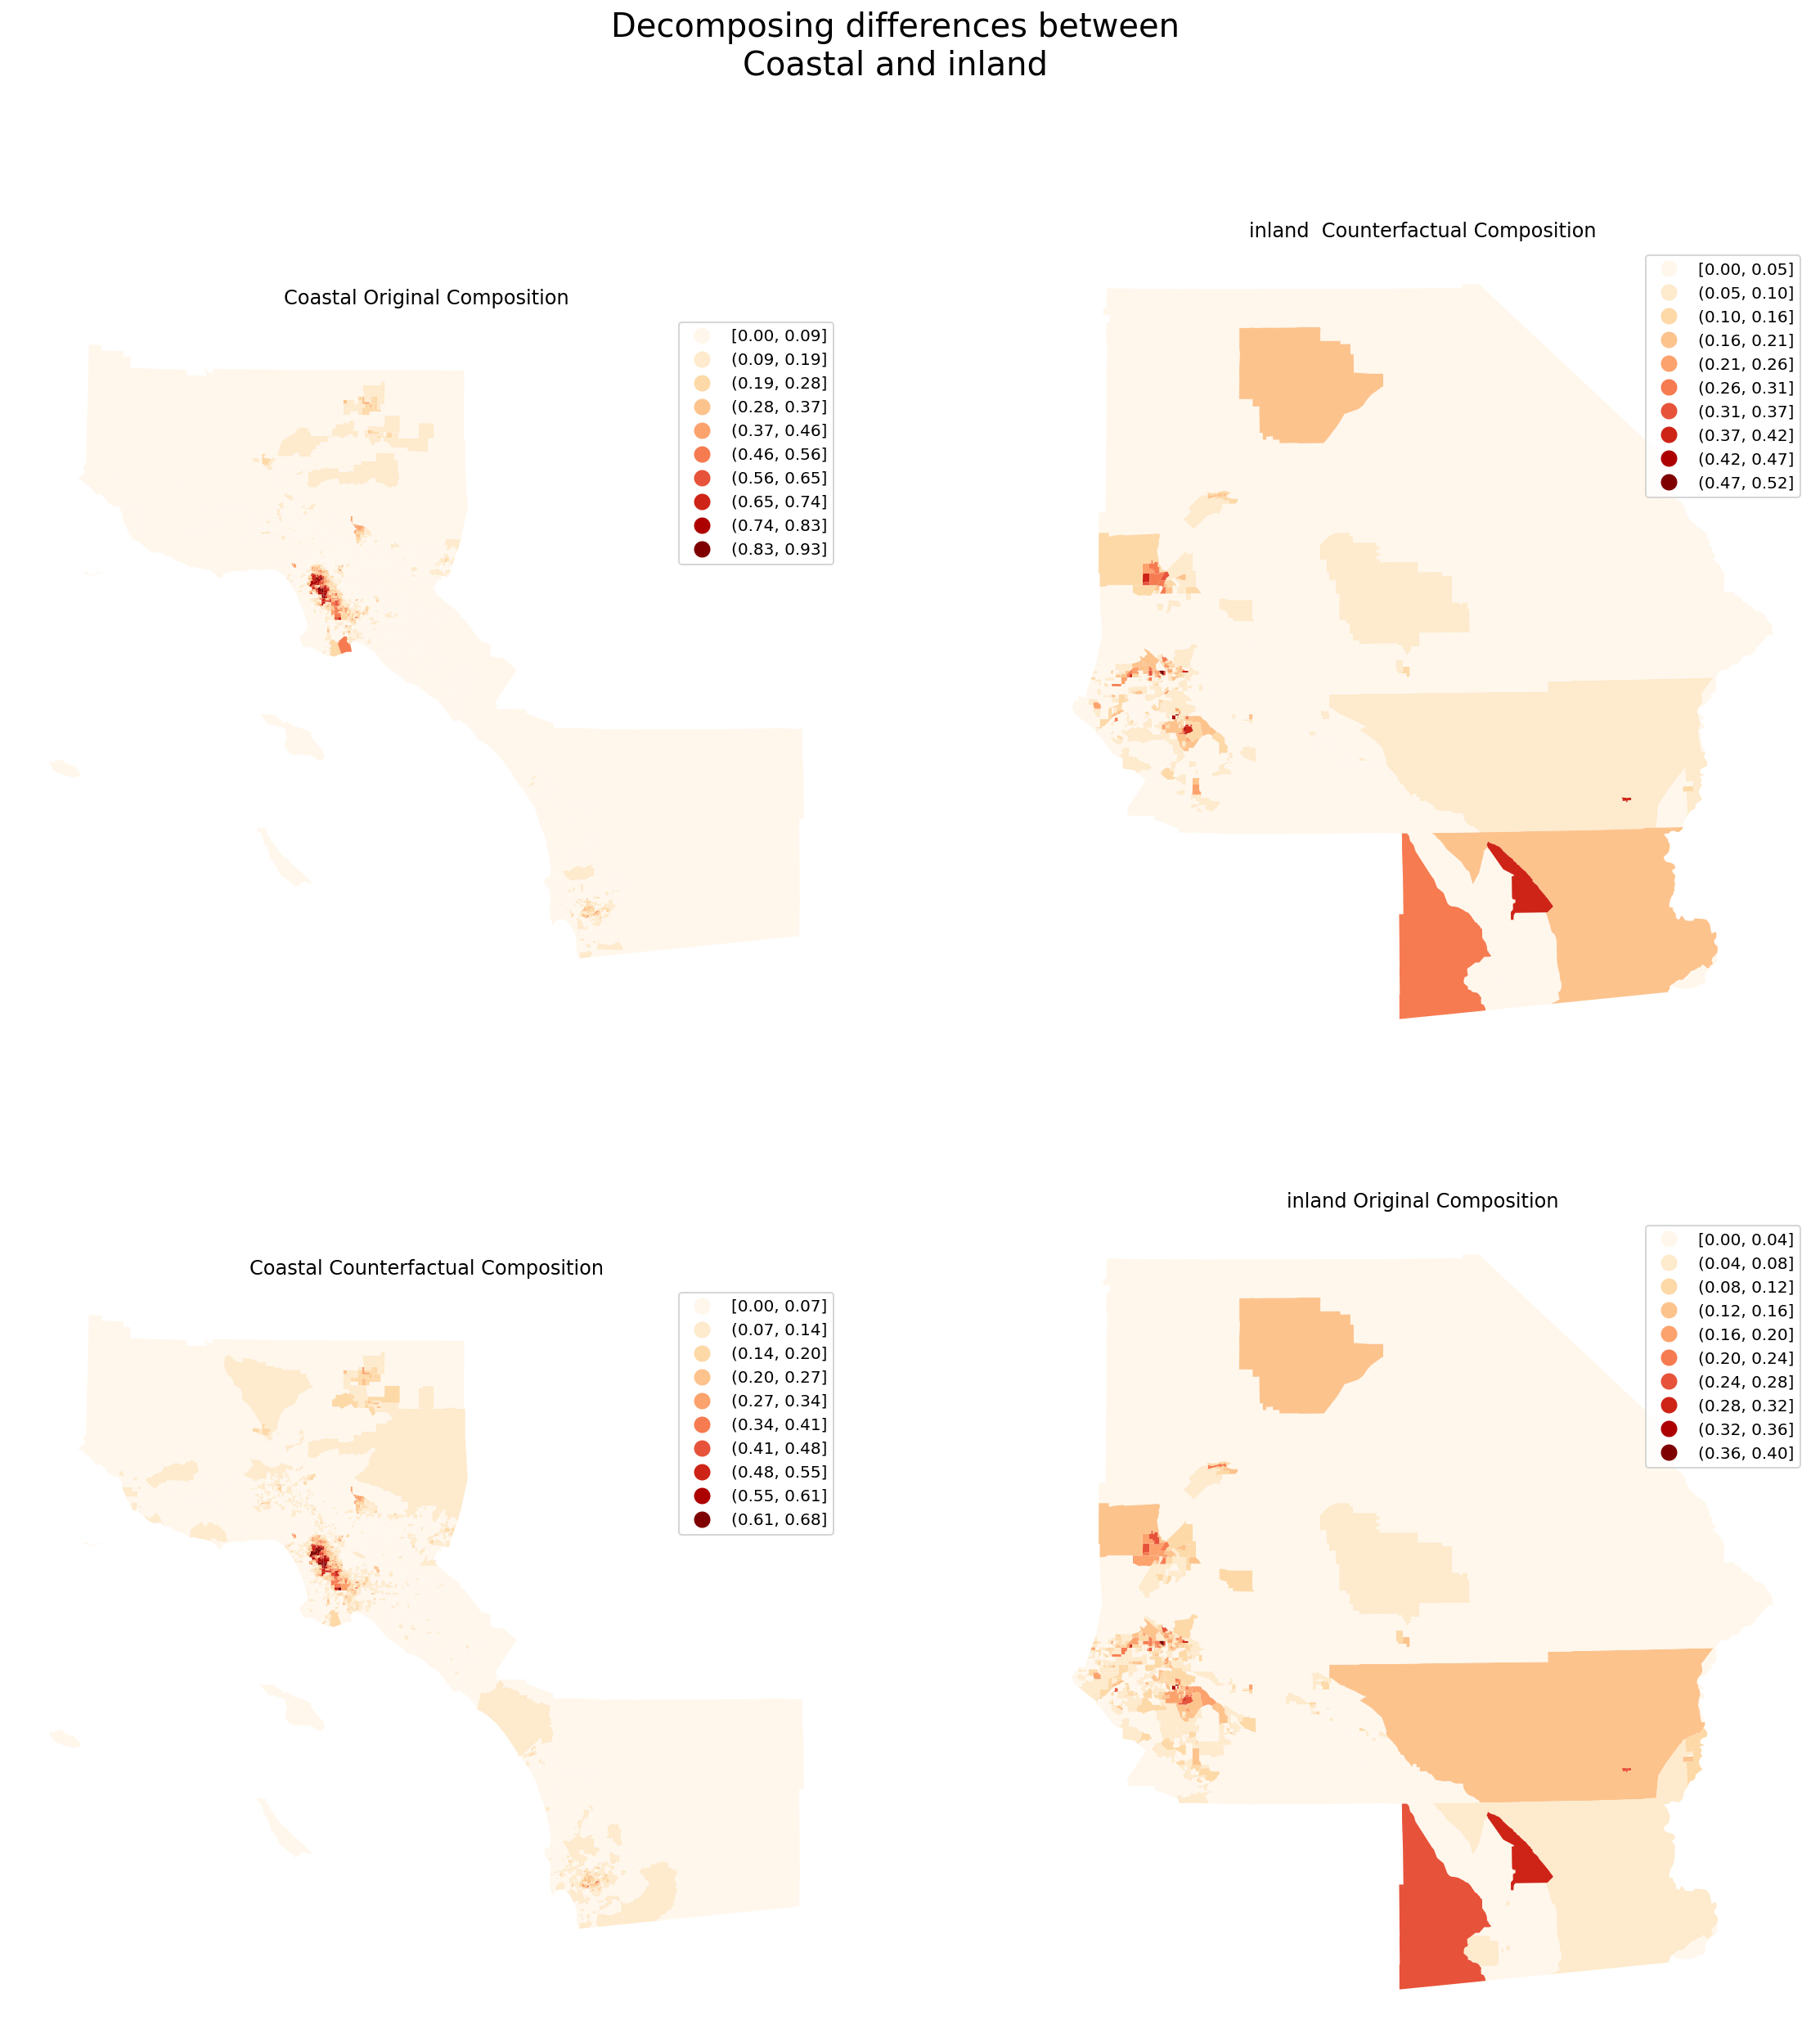

In [48]:
decomp2.plot(plot_type='maps', figsize=(20,20), scheme='equalinterval', k=10, city_a='Coastal', city_b='inland')


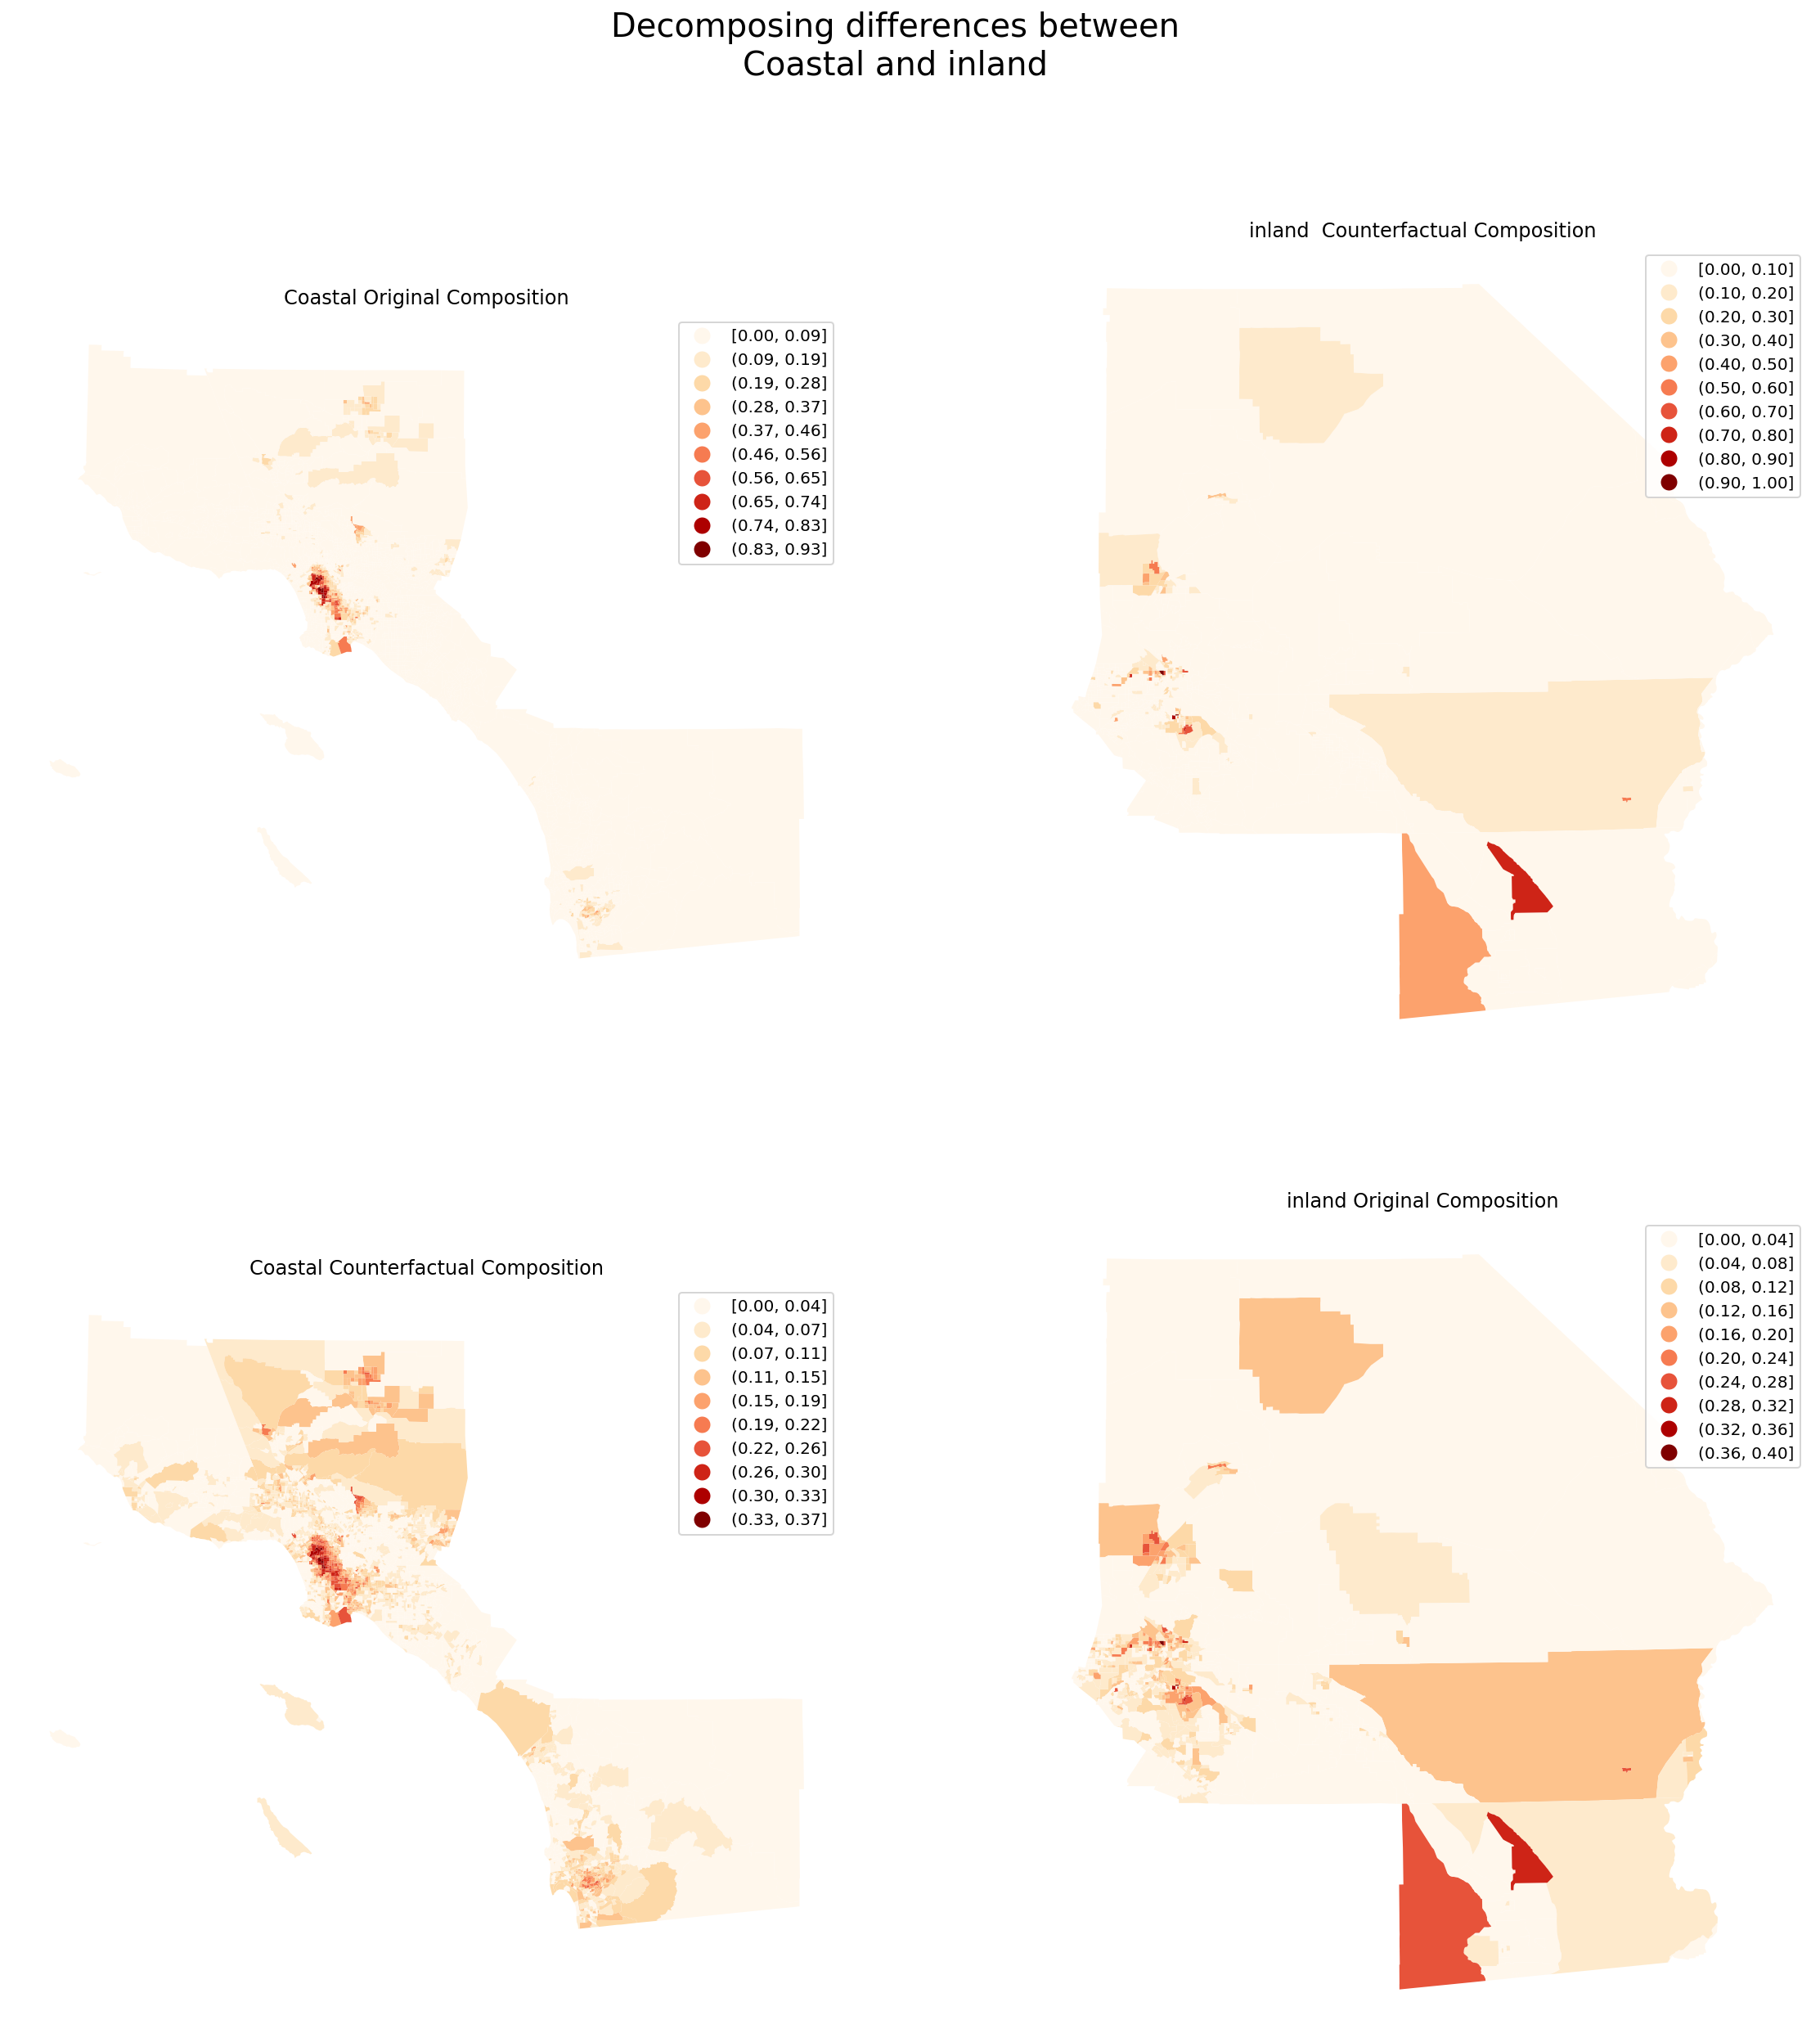

In [49]:
decomp3.plot(plot_type='maps', figsize=(20,20), scheme='equalinterval', k=10, city_a='Coastal', city_b='inland')


## Exercise

1. Which county in the socal region has the greatest level of multiracial segregation, (using the 4 categories above) according to the MultiInformationTheory index?

2. According to the Gini index, is hispanic/latino segregation in Riverside County greater or less than Ventura County? Is that difference significant?

3. According to the Spatial Dissimilarity index, does the difference in segregation between Riverside and Venture result from the demograpic structure or the spatial structure?

Los Angeles Info Theory: 0.31527463754282015
Imperial Info Theory: 0.17746809457072119
Orange Info Theory: 0.22892065055175714
San Bernadino Info Theory: 0.16392378974215477
San Diego Info Theory: 0.20981811797974143
Riverside Info Theory: 0.166612423918606
Ventura Info Theory: 0.22091790646280826

Riverside Gini: 0.5088302506465879
Venura Gini: 0.642912538894819



test significance level = 0.0


/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 163.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/segregation/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 163.
  warnings.warn(message)


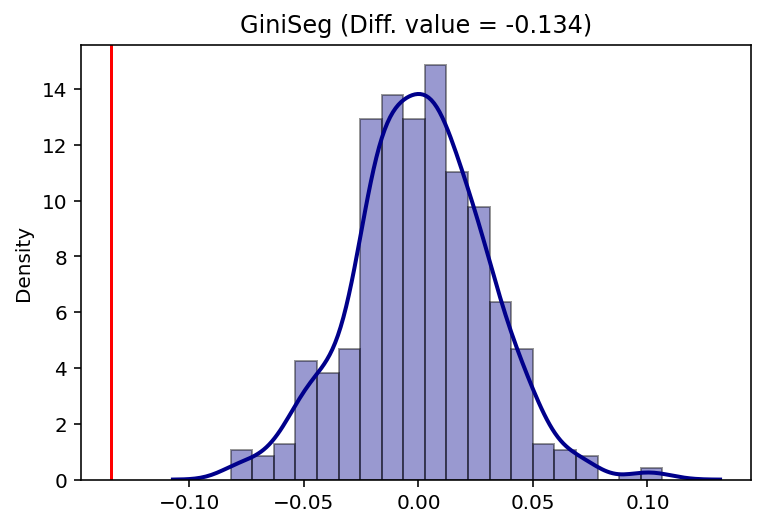

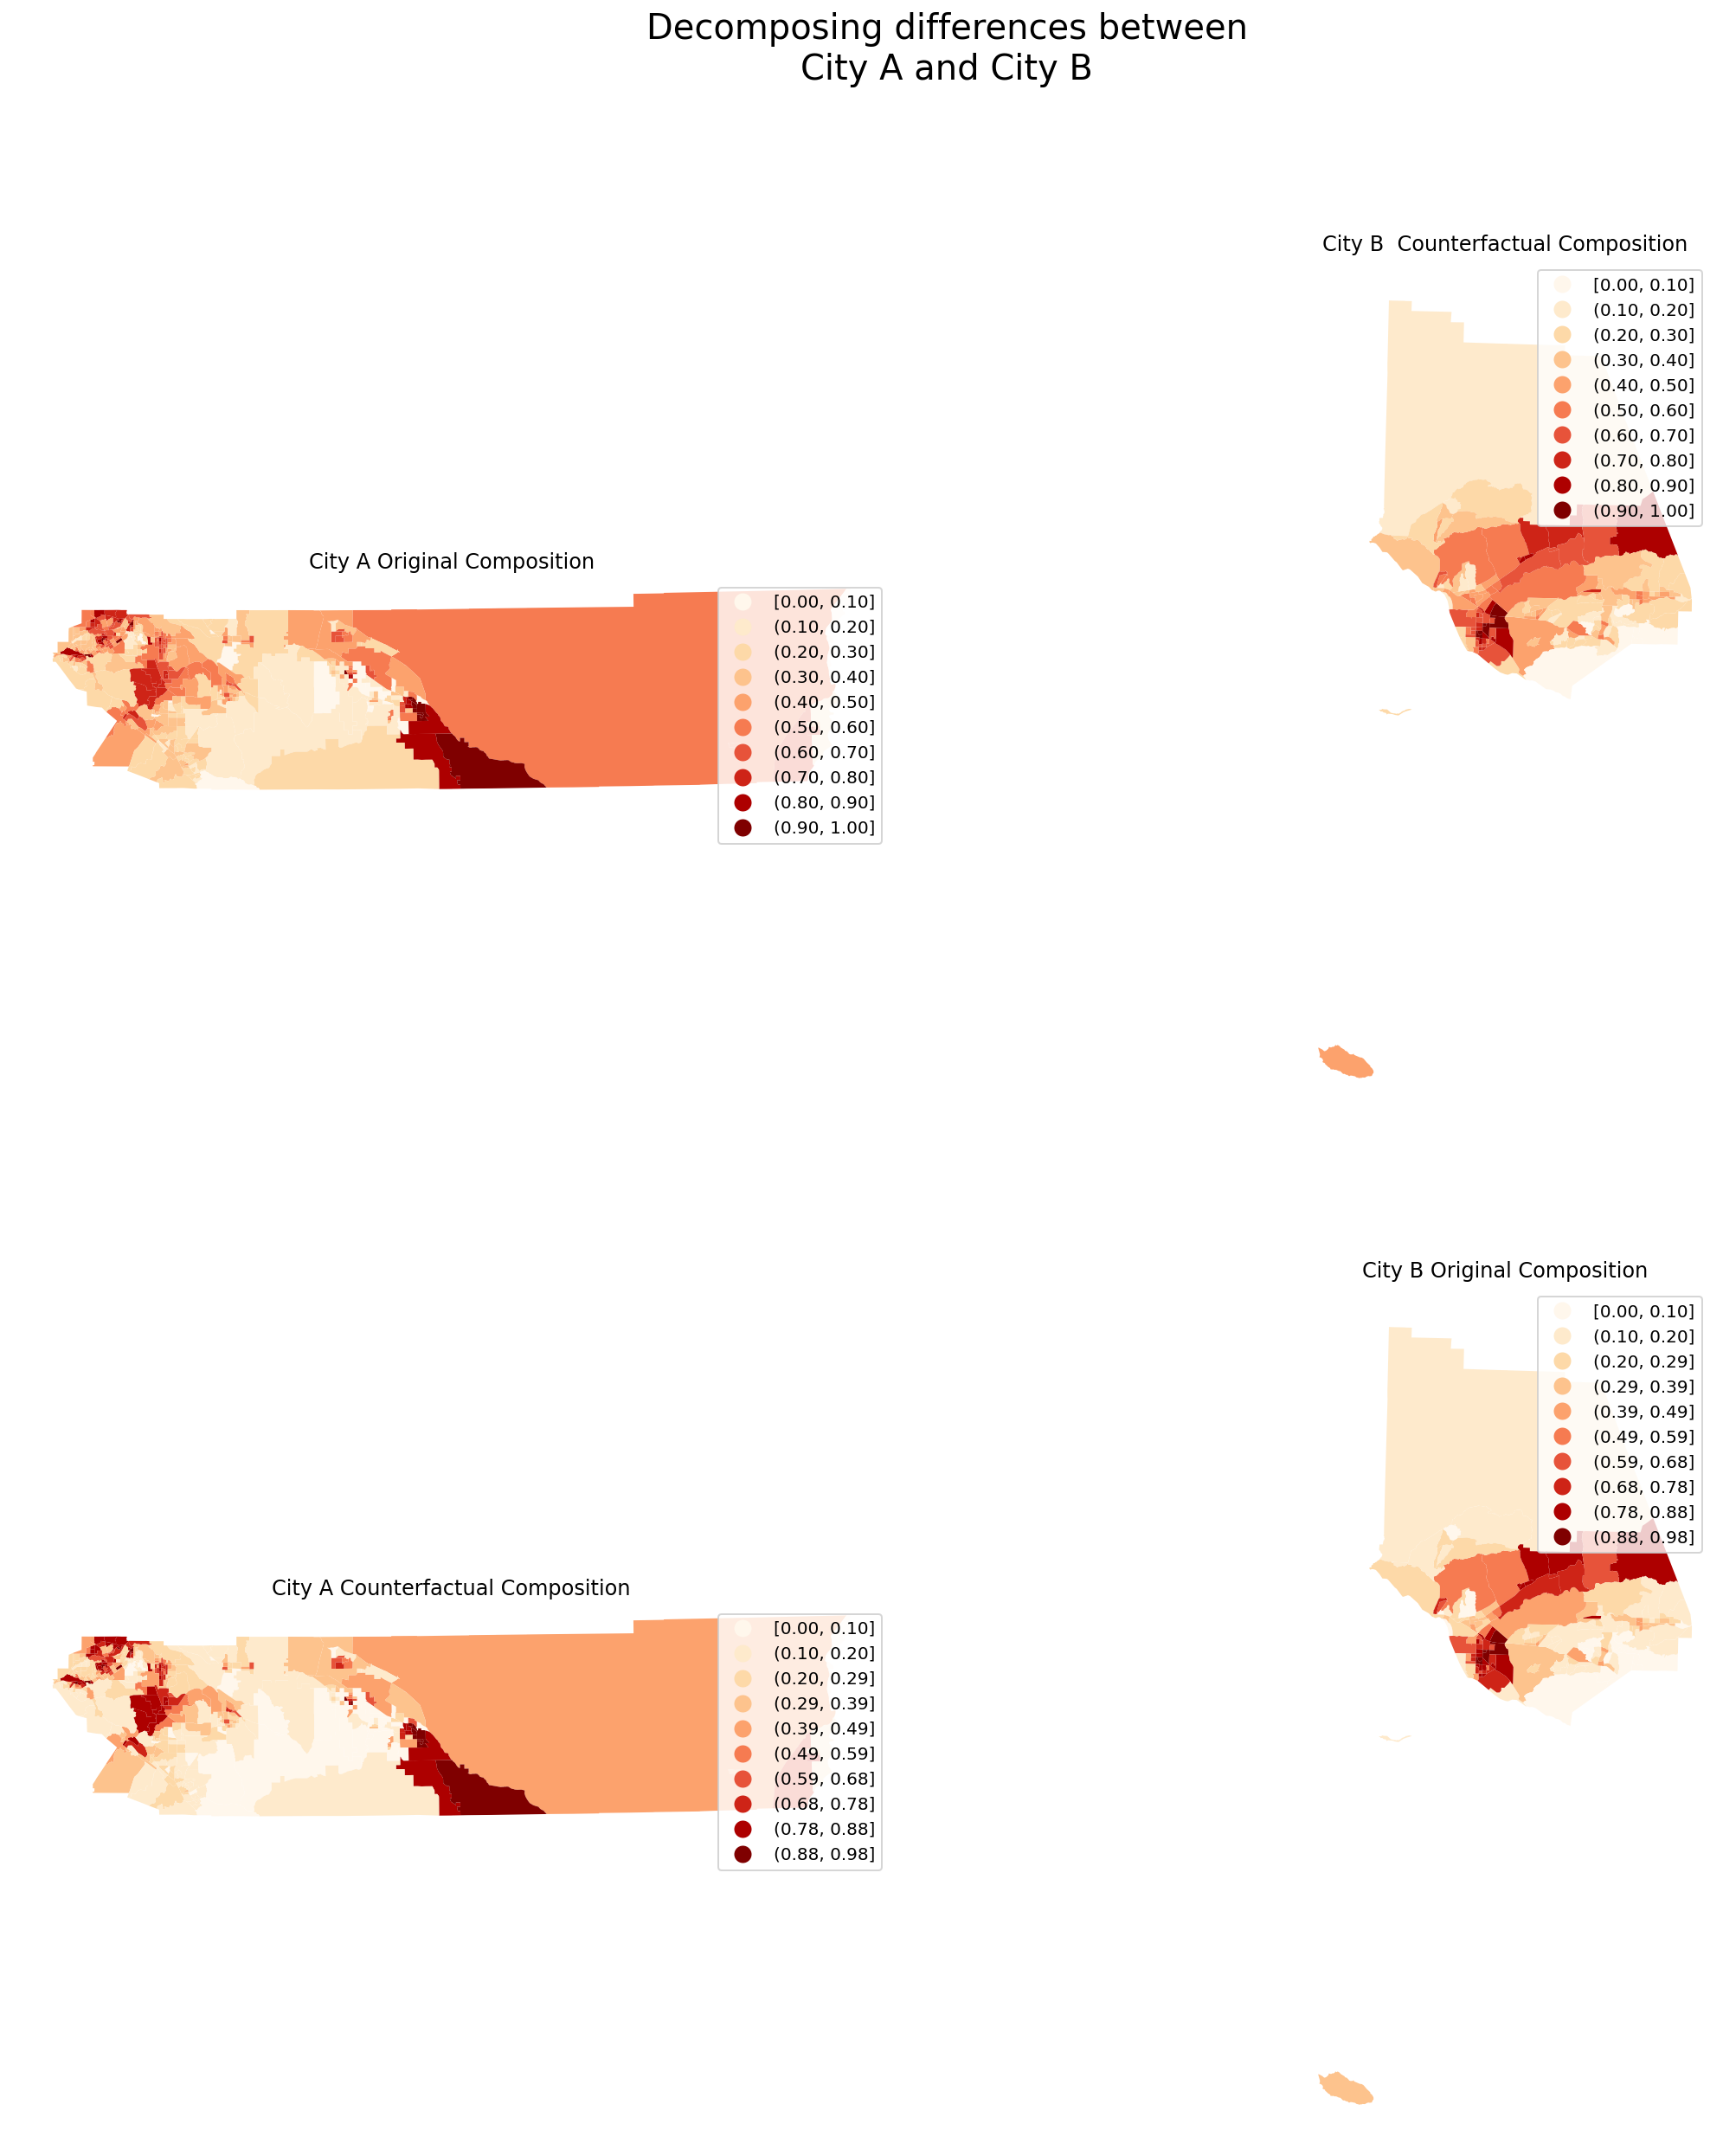

In [60]:
# %load solutions/06.py
#### 1

results = {}

for i in scag.county.unique():

    results[i] = MultiInformationTheory(scag[scag.county==i], pop_groups).statistic
    print(f"{i} Info Theory: {results[i]}")


#### 2

rside_gini = GiniSeg(scag[scag.county=='Riverside'], group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop')
vent_gini = GiniSeg(scag[scag.county=='Ventura'], group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop')

print(f"\nRiverside Gini: {rside_gini.statistic}")
print(f"Venura Gini: {vent_gini.statistic}")
ginitest = TwoValueTest(rside_gini, vent_gini)
print(f"test significance level = {ginitest.p_value}")
ginitest.plot()

#### 3
decomp = DecomposeSegregation(SpatialDissim(scag[scag.county=='Riverside'], group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop'),
                              SpatialDissim(scag[scag.county=='Ventura'], group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop'))
decomp.plot('maps', figsize=(20,20))